# **GOAL**
> This notebook is about basics flow of training neural nets in PyTorch and PyTorch-Lightning. Since PyTorch-Lighting is higher layer API of PyTorch (subclasses of nn.Module), so we won't have to code that much like PyTorch. This is very much similar to fastai, we'll see if it's any better (though I doubt)

# MNIST Classification
> We'll have a try with MNIST dataset

In [1]:
import os
import torch
import torch.cuda
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torchvision import transforms
import ignite.metrics 
from ignite.metrics import Accuracy
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
%matplotlib inline
import pytorch_lightning as pl

In [2]:
# Check torch version & gpu:
torch.__version__, torch.cuda.current_device()

('1.9.0', 0)

## Create datasets
> Let's create our dataset

In [3]:
# Download and create dataset from MNIST
mnist_ds = datasets.MNIST('../data', train=True, download=True, transform=transforms.ToTensor())

# Split train, valid randomly:
train_ds, valid_ds = random_split(mnist_ds, lengths=[55000, 5000])

# Create dataloader with batch_size:
batch_size = 64
train_ds = DataLoader(train_ds, batch_size)
valid_ds = DataLoader(valid_ds, batch_size)

/home/ddpham/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /tmp/pip-req-build-19kunu9c/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Visualize images
> It's always fun to visualize the dataset as much as we can, we know what we're dealing with, even though it's the well known MNIST! 😊

In [4]:
def visualize_images(ds):
    for _, batch in enumerate(ds):
        X, y = batch
        plt.figure(figsize=(3, 3))
        for i in range(9):
            plt.subplot(3, 3, i + 1)
            # plt.imshow(X[i].numpy().reshape(28, 28, 1))
            plt.imshow(np.repeat(X[i].numpy().reshape(28, 28, 1), 3, -1)) # return to 3 channels images
            plt.title(y[i].numpy())
            plt.axis('off')
            plt.tight_layout()
        break

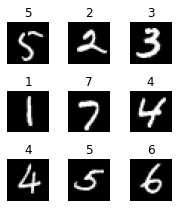

In [5]:
visualize_images(valid_ds)

## Torch stuff
> We're going to create a simple neural nets with `torch.nn` and create a training loop:

### Create simple neural nets

In [119]:
# Create  simple sequential nn:
model = nn.Sequential(
    nn.Linear(28 * 28, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 10),
)
# Move model to cuda:
model.cuda()

parameters = model.parameters()
# Create loss fuction:
loss = nn.CrossEntropyLoss()

# Create optimizer, keep default stuff:
lr = 1e-3
optimizer = optim.Adam(parameters, lr = lr)

### Training loops

In [127]:
# Create a training, validatign loops:
EPOCHS = 10
for epoch in range(EPOCHS):
    # Create train & valid losses & accuracies:
    train_loss = list()
    valid_loss = list()
    train_accuracy = list()
    valid_accuracy = list()
    # loop through every batch of train_ds:
    for batch in train_ds:
        x, y = batch
        
        # Convert X to batch_size x 1 x 28 x 28:
        batch_size = x.size(0)
        x = x.view(batch_size, -1).cuda() # move x upto cuda so all steps calcuation related to x will be on cuda.
        
        # Step 1: forward step:
        f = model(x)
        
        # Step 2: Compute loss value:
        l = loss(f, y.cuda())
        
        # Step 3a: zero_grad (make all gradients to zero before accumulate them via nn):
        model.zero_grad()
        
        # Step 3b: accumulate gradients via all nns 
        l.backward()
        
        # Step 4: make updates (step) of the params based on gradients:
        optimizer.step()
        
        # Append to loss and accuracies:
        train_loss.append(l.item())
        train_accuracy.append(y.eq(f.detach().argmax(dim=1).cpu()).float().mean())
    
    # loop through every batch of train_ds:
    for batch in valid_ds:
        x, y = batch
        batch_size = x.size(0)
        x = x.view(batch_size, -1).cuda()
        with torch.no_grad(): f = model(x)
        l = loss(f, y.cuda())
        
        # Append to loss and accuracies:
        valid_loss.append(l.item())
        valid_accuracy.append(y.eq(f.detach().argmax(dim=1).cpu()).float().mean())
        
    # After done with epoch, print loss of valid and train:
    print(f'Epoch {epoch + 1}:  train_loss: {torch.tensor(train_loss).mean(): .2f},\
    train_accuracy: {torch.tensor(train_accuracy).mean(): .2f},\
    valid_loss: {torch.tensor(valid_loss).mean(): .2f},\
    valid_accuracy: {torch.tensor(valid_accuracy).mean(): .2f}')

Epoch 1:  train_loss:  0.08,    train_accuracy:  0.97,    valid_loss:  0.12,    valid_accuracy:  0.96
Epoch 2:  train_loss:  0.07,    train_accuracy:  0.98,    valid_loss:  0.12,    valid_accuracy:  0.97
Epoch 3:  train_loss:  0.06,    train_accuracy:  0.98,    valid_loss:  0.11,    valid_accuracy:  0.97
Epoch 4:  train_loss:  0.05,    train_accuracy:  0.99,    valid_loss:  0.12,    valid_accuracy:  0.97
Epoch 5:  train_loss:  0.04,    train_accuracy:  0.99,    valid_loss:  0.12,    valid_accuracy:  0.97
Epoch 6:  train_loss:  0.03,    train_accuracy:  0.99,    valid_loss:  0.13,    valid_accuracy:  0.97
Epoch 7:  train_loss:  0.03,    train_accuracy:  0.99,    valid_loss:  0.12,    valid_accuracy:  0.97
Epoch 8:  train_loss:  0.02,    train_accuracy:  0.99,    valid_loss:  0.12,    valid_accuracy:  0.97
Epoch 9:  train_loss:  0.02,    train_accuracy:  0.99,    valid_loss:  0.13,    valid_accuracy:  0.97
Epoch 10:  train_loss:  0.02,    train_accuracy:  0.99,    valid_loss:  0.13,    v

### Update model with dropout
> add dropout to reduce overfit

In [137]:
# Create  simple sequential nn:
model = nn.Sequential(
    nn.Linear(28 * 28, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Dropout(.2),
    nn.Linear(64, 10),
)
# Move model to cuda:
model.cuda()

parameters = model.parameters()
# Create loss fuction:
loss = nn.CrossEntropyLoss()

# Create optimizer, keep default stuff:
lr = 1e-3
optimizer = optim.Adam(parameters, lr = lr)

In [138]:
# Create a training, validatign loops:
EPOCHS = 10
for epoch in range(EPOCHS):
    # Create train & valid losses & accuracies:
    train_loss = list()
    valid_loss = list()
    train_accuracy = list()
    valid_accuracy = list()
    # loop through every batch of train_ds:
    for batch in train_ds:
        x, y = batch
        batch_size = x.size(0)
        x = x.view(batch_size, -1).cuda() # move x upto cuda so all steps calcuation related to x will be on cuda.
        f = model(x)
        l = loss(f, y.cuda())
        model.zero_grad()
        l.backward()
        optimizer.step()
        # Append to loss and accuracies:
        train_loss.append(l.item())
        train_accuracy.append(y.eq(f.detach().argmax(dim=1).cpu()).float().mean())
    
    # loop through every batch of train_ds:
    for batch in valid_ds:
        x, y = batch
        batch_size = x.size(0)
        x = x.view(batch_size, -1).cuda()
        with torch.no_grad(): f = model(x)
        l = loss(f, y.cuda())
        # Append to loss and accuracies:
        valid_loss.append(l.item())
        valid_accuracy.append(y.eq(f.detach().argmax(dim=1).cpu()).float().mean())
        
    # After done with epoch, print loss of valid and train:
    print(f'Epoch {epoch + 1}:  train_loss: {torch.tensor(train_loss).mean(): .2f},\
    train_accuracy: {torch.tensor(train_accuracy).mean(): .2f},\
    valid_loss: {torch.tensor(valid_loss).mean(): .2f},\
    valid_accuracy: {torch.tensor(valid_accuracy).mean(): .2f}')

Epoch 1:  train_loss:  0.45,    train_accuracy:  0.87,    valid_loss:  0.25,    valid_accuracy:  0.93
Epoch 2:  train_loss:  0.20,    train_accuracy:  0.94,    valid_loss:  0.19,    valid_accuracy:  0.95
Epoch 3:  train_loss:  0.15,    train_accuracy:  0.95,    valid_loss:  0.17,    valid_accuracy:  0.95
Epoch 4:  train_loss:  0.12,    train_accuracy:  0.96,    valid_loss:  0.15,    valid_accuracy:  0.95
Epoch 5:  train_loss:  0.10,    train_accuracy:  0.97,    valid_loss:  0.13,    valid_accuracy:  0.96
Epoch 6:  train_loss:  0.08,    train_accuracy:  0.97,    valid_loss:  0.14,    valid_accuracy:  0.96
Epoch 7:  train_loss:  0.07,    train_accuracy:  0.98,    valid_loss:  0.13,    valid_accuracy:  0.97
Epoch 8:  train_loss:  0.07,    train_accuracy:  0.98,    valid_loss:  0.12,    valid_accuracy:  0.97
Epoch 9:  train_loss:  0.06,    train_accuracy:  0.98,    valid_loss:  0.12,    valid_accuracy:  0.97
Epoch 10:  train_loss:  0.05,    train_accuracy:  0.98,    valid_loss:  0.13,    v

In [151]:
# Create a model with nn.Module:
class nn_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(28*28, 64)
        self.l2 = nn.Linear(64, 64)
        self.l3 = nn.Linear(64, 10)
        self.do = nn.Dropout(.5)
        
    def forward(self, x):
        h1 = nn.functional.relu(self.l1(x))
        h2 = nn.functional.relu(self.l2(h1))
        do = self.do(h2 + h1)
        logits = self.l3(do)
        return logits

model = nn_model()
model.cuda()

nn_model(
  (l1): Linear(in_features=784, out_features=64, bias=True)
  (l2): Linear(in_features=64, out_features=64, bias=True)
  (l3): Linear(in_features=64, out_features=10, bias=True)
  (do): Dropout(p=0.2, inplace=False)
)

In [152]:
# Create loss and optimizer:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [153]:
# Create a training, validatign loops:
EPOCHS = 10
for epoch in range(EPOCHS):
    # Create train & valid losses & accuracies:
    train_loss = list()
    valid_loss = list()
    train_accuracy = list()
    valid_accuracy = list()
    # loop through every batch of train_ds:
    for batch in train_ds:
        x, y = batch
        batch_size = x.size(0)
        x = x.view(batch_size, -1).cuda() # move x upto cuda so all steps calcuation related to x will be on cuda.
        f = model(x)
        l = loss(f, y.cuda())
        model.zero_grad()
        l.backward()
        optimizer.step()
        # Append to loss and accuracies:
        train_loss.append(l.item())
        train_accuracy.append(y.eq(f.detach().argmax(dim=1).cpu()).float().mean())
    
    # loop through every batch of train_ds:
    for batch in valid_ds:
        x, y = batch
        batch_size = x.size(0)
        x = x.view(batch_size, -1).cuda()
        with torch.no_grad(): f = model(x)
        l = loss(f, y.cuda())
        # Append to loss and accuracies:
        valid_loss.append(l.item())
        valid_accuracy.append(y.eq(f.detach().argmax(dim=1).cpu()).float().mean())
        
    # After done with epoch, print loss of valid and train:
    print(f'Epoch {epoch + 1}:  train_loss: {torch.tensor(train_loss).mean(): .2f},\
    train_accuracy: {torch.tensor(train_accuracy).mean(): .2f},\
    valid_loss: {torch.tensor(valid_loss).mean(): .2f},\
    valid_accuracy: {torch.tensor(valid_accuracy).mean(): .2f}')

Epoch 1:  train_loss:  0.42,    train_accuracy:  0.88,    valid_loss:  0.23,    valid_accuracy:  0.93
Epoch 2:  train_loss:  0.19,    train_accuracy:  0.94,    valid_loss:  0.17,    valid_accuracy:  0.95
Epoch 3:  train_loss:  0.14,    train_accuracy:  0.96,    valid_loss:  0.13,    valid_accuracy:  0.96
Epoch 4:  train_loss:  0.11,    train_accuracy:  0.97,    valid_loss:  0.13,    valid_accuracy:  0.96
Epoch 5:  train_loss:  0.09,    train_accuracy:  0.97,    valid_loss:  0.12,    valid_accuracy:  0.96
Epoch 6:  train_loss:  0.08,    train_accuracy:  0.98,    valid_loss:  0.12,    valid_accuracy:  0.96
Epoch 7:  train_loss:  0.07,    train_accuracy:  0.98,    valid_loss:  0.12,    valid_accuracy:  0.97
Epoch 8:  train_loss:  0.06,    train_accuracy:  0.98,    valid_loss:  0.11,    valid_accuracy:  0.97
Epoch 9:  train_loss:  0.05,    train_accuracy:  0.98,    valid_loss:  0.12,    valid_accuracy:  0.97
Epoch 10:  train_loss:  0.05,    train_accuracy:  0.99,    valid_loss:  0.12,    v

## Lightning

For pytorch-lightning, we need to define:
1. Model - similar to pytorch
2. Optimizer

In [193]:
import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy

In [209]:
# Create model:
class ImageClassifie(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(28 * 28, 64)
        self.l2 = nn.Linear(64, 64)
        self.l3 = nn.Linear(64, 10)
        self.do = nn.Dropout(.5)
        
        # adding loss:
        self.loss = nn.CrossEntropyLoss()
    
    def forward(self, x):
        h1 = nn.functional.relu(self.l1(x))
        h2 = nn.functional.relu(self.l2(h1))
        do = self.do(h2 + h1)
        logits = self.l3(do)
        return logits
    
    # added method:
    def configure_optimizers(self):
        optimizer= optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
    
    # adđe method:
    def training_step(self, batch, batch_idx):
        x, y = batch
        batch_size = x.size(0)
        x = x.view(batch_size, -1)
        f = self(x)
        l = self.loss(f, y)
        acc = accuracy(f, y)
        bpar = {'train_acc': acc}
        # return l   
        return {'Loss': l, 'progress_bar': pbar}
    
    def validation_step(self, batch, batch_idx):
        results = self.training_step(batch, batch_idx)
        results['progress_bar']['val_acc'] = results['progress_bar']['train_acc']
        del results['progress_bar']['train_acc']
        return results
    
    def validation_epoch_end(self, val_step_outputs):
        avg_val_loss = torch.tensor([x['Loss'] for x in val_step_outputs]).mean()
        avg_val_acc = torch.tensor([x['progress_bar']['val_acc'] for ax in val_step_outputs]).mean()
        pbar = {'val_acc': avg_val_acc}
        return {'val_loss': avg_val_loss, 'progress_bar': pbar}
    
    def prepare_data(self):
        datasets.MNIST('../data', train=True, download=True, transform=transforms.ToTensor())
    
    def setup(self):
        dataset = datasets.MNIST('../data', train=False, download=True, transform=transforms.ToTensor())
        # Split train, valid randomly:
        self.train_ds, self.valid_ds = random_split(mnist_ds, lengths=[55000, 5000])
    
    # added method:
    def train_dataloader(self):

        # Create dataloader with batch_size:
        batch_size = 64
        train_ds = DataLoader(self.train_ds, batch_size)
        return train_ds
    
    def valid_dataloader(self):
        batch_size = 64
        valid_ds = DataLoader(self.valid_ds, batch_size)
        return train_ds
    

In [210]:
model = ImageClassifier()
model

ImageClassifier(
  (l1): Linear(in_features=784, out_features=64, bias=True)
  (l2): Linear(in_features=64, out_features=64, bias=True)
  (l3): Linear(in_features=64, out_features=10, bias=True)
  (do): Dropout(p=0.5, inplace=False)
  (loss): CrossEntropyLoss()
)

In [211]:
trainer = pl.Trainer(progress_bar_refresh_rate=20, max_epochs=5, gpus=1)
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type             | Params
------------------------------------------
0 | l1   | Linear           | 50.2 K
1 | l2   | Linear           | 4.2 K 
2 | l3   | Linear           | 650   
3 | do   | Dropout          | 0     
4 | loss | CrossEntropyLoss | 0     
------------------------------------------
55.1 K    Trainable params
0         Non-trainable params
55.1 K    Total params
0.220     Total estimated model params size (MB)


Training: -1it [00:00, ?it/s]

# W&B tag along
> Now we're going to add some wandb code into this so that we can see the results of our work as well. Let's say we'll split into pytorch implementation and pytorch lightning implementation as well.

## W&B with pytorch

In [242]:
#State our device:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [243]:
# Import W&B and login
import wandb
wandb.login()

True

In [244]:
PROJECT_NAME='torch_experiments_mnist'

In [253]:
# Create config:
config = dict(
    epochs=5,
    classes=10,
    kernels=[16, 32],
    batch_size=128,
    learning_rate=3e-4,
    dataset='MNIST',
    architecture='CNN'
)

### Create pipeline

Next we want to create a pipeline for model:
1. Create model
2. Train model
3. Test model

In [254]:
def model_pipeline(hyperparameters):
    # tell wandb to start:
    with wandb.init(project=PROJECT_NAME, config=hyperparameters):
        # access all HPs through wandb.config, so logging matches excutions
        config = wandb.config
        
        # make model, train_loader, test_loader, loss, optimizer:
        print('Make configurations:')
        model, train_loader, test_loader, loss, optimizer = make(config)
        print(model)
        
        # train model:
        print('Train model:')
        train(model, train_loader, loss, optimizer, config)
        
        # test model:
        print('Test model:')
        test(model, test_loader)
        
    return model

### Make configurations

In [255]:
# Create make(config):
def make(config):
    # make data:
    print('--Create train, test loaders:')
    train, test = get_data(train=True), get_data(train=False) # Here we need to defind get_data
    train_loader = create_dataloader(train, batch_size=config.batch_size)
    test_loader = create_dataloader(test, batch_size=config.batch_size)
    
    # make model:
    print('--Create model:')
    model = ConvNet(config.kernels, config.classes).to(device)
    
    # make loss and optimizer:
    print('--Create loss and optimizer)
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
    return model, train_loader, test_loader, loss, optimizer

### Create dataloader

In [256]:
# Create data loader:
def get_data(slice=5, train=True):
    dataset = datasets.MNIST('./data', train=train, transform=transforms.ToTensor(), download=True)
    # Using subset to get data:
    sub_dataset = torch.utils.data.Subset(dataset, indices=range(0, len(dataset), slice))
    return sub_dataset
    
def create_dataloader(dataset, batch_size):
    dataloader = DataLoader(dataset, batch_size, shuffle=True, pin_memory=True)
    return dataloader

### Create model

In [262]:
# Create simple Convolutional Net:
class ConvNet(nn.Module):
    def __init__(self, kernels, classes):
        super(ConvNet, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, kernels[0], kernel_size=5, stride=1, padding=2), # after this, size = (28 + 2 * 2 -5)/1 + 1 = 28 (size + 2* pad - kernel)/stride + 1, 16 channels
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # after this, size = (28-2)/2 + 1 = 14, channels = kernels[0] (kernels[0]x14x14)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, kernels[1], kernel_size=5, stride=1, padding=2), # new size = 14, channels = kernels[1] (kenels[1]x14x14)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # new size = (14-2)/2 + 1 = 7, channels = kernels[1], (kenels[1]x7x7)
        )
        self.fc = nn.Linear(7 * 7 * kernels[1], classes)
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

### Create train loop
> In this training loop, we want to capture gradients with `wandb.watch()` whilst other hyperparameters with `wandb.log()`

In [259]:
# Define train loop:
def train(model, data_loader, loss, optimizer, config):
    # tell wandb to log gradients, weights & others:
    print('--Init wandb watch:')
    wandb.watch(model, loss, log='all', log_freq=10)
    
    # run training steps and ask wandb to log things:
    print('--loop through epochs:')
    total_baches = len(data_loader) * config.epochs
    example_ct = 0
    batch_ct = 0
    for epoch in tqdm(range(config.epochs)):
        for _, (images, labels) in enumerate(data_loader):
            batch_loss = train_batch(images, labels, model, optimizer, loss)
            example_ct += 1
            batch_ct += 1
            
            # report metrics for every 25 batchs:
            if ((batch_ct + 1) % 25) == 0:
                train_log(batch_loss, example_ct, epoch)
        
# Define batch training:
def train_batch(images, labels, model, optimizer, loss):
    # place x & y to device we want to:
    images, labels = images.to(device), labels.to(device)
    
    # forward pass:
    f = model(images)
    batch_loss = loss(f, labels)
    
    # backward pass:
    optimizer.zero_grad()
    batch_loss.backward()
    
    # update weights with gradients (step):
    optimizer.step()    
    return batch_loss
    

# Define what to log during training:
def train_log(batch_loss, example_ct, epoch):
    batch_loss = float(batch_loss)
    
    # call wandb to log things:
    wandb.log({'epoch': epoch, 'loss': batch_loss}, step=example_ct)
    print(f'Loss after:' + str(example_ct).zfill(5) + f' examples: {batch_loss: .3f}')

### Create test loop:

In [271]:
def test(model, test_loader):
    model.eval()

    # Run the model on some test examples
    with torch.no_grad():
        correct, total = 0, 0
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            f = model(images)
            _, labels_hat = torch.max(f.data, 1)
            total += labels.size(0)
            correct += (labels_hat == labels).sum().item()

        print(f"Accuracy of the model on the {total} " +
              f"test images: {100 * correct / total}%")
        
        wandb.log({"test_accuracy": correct / total})

    # Save the model in the exchangeable ONNX format
    torch.onnx.export(model, images, "model.onnx")
    wandb.save("model.onnx")

In [272]:
%%capture
!pip install wandb --upgrade

In [273]:
# Run every thing:
model = model_pipeline(config)

wandb: wandb version 0.12.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)
--Init wandb watch:
--loop through epochs:


  0%|          | 0/5 [00:00<?, ?it/s]

Loss after:00024 examples:  2.077
Loss after:00049 examples:  1.384
Loss after:00074 examples:  0.709
Loss after:00099 examples:  0.554
Loss after:00124 examples:  0.391
Loss after:00149 examples:  0.366
Loss after:00174 examples:  0.351
Loss after:00199 examples:  0.299
Loss after:00224 examples:  0.280
Loss after:00249 examples:  0.217
Loss after:00274 examples:  0.186
Loss after:00299 examples:  0.247
Loss after:00324 examples:  0.192
Loss after:00349 examples:  0.256
Loss after:00374 examples:  0.221
Loss after:00399 examples:  0.216
Loss after:00424 examples:  0.185
Loss after:00449 examples:  0.107
Accuracy of the model on the 2000 test images: 93.95%


_runtime,22
_timestamp,1632783009
_step,449
epoch,4
loss,0.10737
test_accuracy,0.9395


_runtime,▁▁▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇██
_step,▁▁▂▂▃▃▃▄▄▄▅▅▆▆▆▇▇██
epoch,▁▁▁▃▃▃▃▅▅▅▅▆▆▆▆███
loss,█▆▃▃▂▂▂▂▂▁▁▁▁▂▁▁▁▁
test_accuracy,▁


In [275]:
wandb.finish()

## W&B with pytorch-lightning

In [19]:
from torchvision.datasets import MNIST
import torch.nn.functional as F
from pytorch_lightning.loggers import WandbLogger
pl.seed_everything(hash("setting random seeds") % 2**32 - 1)
import wandb
wandb.login()

Global seed set to 497020700
wandb: W&B API key is configured (use `wandb login --relogin` to force relogin)


True

In [28]:
# We're going to redo what we did before with pytorhc-lightning:
class ImageClassifier(pl.LightningModule):
    def __init__(self, in_dims, n_classes=10, n_layer1=128, n_layer2=256, lr=3e-4):
        super().__init__()
        # Create layers:
        self.l1 = nn.Linear(np.prod(in_dims), n_layer1)
        self.l2 = nn.Linear(n_layer1, n_layer2)
        self.l3 = nn.Linear(n_layer2, n_classes)
        
        # log parameters:
        self.save_hyperparameters()
        
        # Compute accuracy:
        self.train_acc = pl.metrics.Accuracy()
        self.valid_acc = pl.metrics.Accuracy()
        self.test_acc = pl.metrics.Accuracy()
        
    def forward(self, x):
        batch_size, *dims = x.size()
        
        # Stem:
        x = x.view(batch_size, -1)
        
        # Learner:
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        
        # task: compute logits:
        x = F.log_softmax(self.l3(x), dim=1)
        
        return x
    
    # Method to get loss:
    def loss(self, xs, ys):
        logits = self(xs) # call forward
        loss = F.nll_loss(logits, ys)
        return logits, loss
    
    # Add method: trainning_step
    def training_step(self, batch, batch_idx):
        xs, ys = batch
        logits, loss = self.loss(xs, ys)
        preds =  torch.argmax(logits, 1)
        
        # Logging metrics we calculate
        self.log('train/loss', loss, on_epoch=True)
        
        # Logging pl.Metric:
        self.train_acc(preds, ys)
        self.log('train/acc', self.train_acc, on_epoch=True)
        return loss
        
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.hparams['lr'])

### Optinal method for logging
> We need to create callbacks from this:
- Methods that trigger each batch for a dataset: `validation_step` and `test_step`
- Methods that trigger at the end of an epoch: `{training|validation|test}_epoch_end`

**Test step:**

In [5]:
def test_step(self, batch, batch_idx):
    xs, ys = batch
    logits, loss = self.loss(xs, ys)
    preds = torch.argmax(logits, 1)
    self.log('test/loss_epoch', loss, on_step=False, on_epoch=True)
    self.log('test/acc_epoch', self.test_acc, on_step=False, on_epoch=True)
    
# Update to ImageClassifier:
ImageClassifier.test_step = test_step

In [6]:
# Save model:
def test_epoch_end(self, test_step_outputs):
    dummy_input = torch.zeros(self.hparams['in_dims'], device=self.device)
    model_filename = 'model_final.onnx'
    torch.onnx.export(self, dummy_input, model_filename, opset_version=11)
    
ImageClassifier.test_epoch_end = test_epoch_end

**Validation step**

In [7]:
def validation_step(self, batch, batch_idx):
    xs, ys = batch
    logits, loss = self.loss(xs, ys)
    preds = torch.argmax(logits, 1)
    self.valid_acc(preds, ys)
    
    # log:
    self.log('validation/loss_epoch', loss)
    self.log('validation/acc_epoch', self.valid_acc)
    
    return logits

def validation_epoch_end(self, validation_epoch_outputs):
    dump_input = torch.zeros(self.hparams['in_dims'], device=self.device)
    model_filename = f'model_{str(self.global_step).zfill(5)}.onnx'
    torch.onnx.export(self, dummy_input, model_filename, opset_version=11)
    wandb.save(model_filename)
    
    flattend_logits = torch.flatten(torch.cat(validation_epoch_outputs))
    self.logger.experiment.log(
        {'valid/logits': wandb.Histogram(flattend_logits.to('cpu')),
         'global_step': self.global_step}
    )
    
ImageClassifier.validation_step = validation_step
ImageClassifier.valid_epoch_end = validation_epoch_end

### Callbacks

In [10]:
# Create callback to log further things:
class ImagePredictionLogger(pl.Callback):
    def __init__(self, val_samples, num_samples=32):
        super().__init__()
        self.val_images, self.val_labels = val_samples
        self.val_images = self.val_images[:num_samples]
        self.val_labels = self.val_labels[:num_samples]
        
    def on_validation_epoch_end(self, trainer, pl_module):
        val_images = self.val_images.to(device=pl_module.device)
        
        logits = pl_module(val_images)
        preds = torch.argmax(logits, 1)
        
        trainer.logger.experiment.log(
            {'examples': [wandb.Image(x, caption=f'Pred:{pred}, Labels{y}')
                         for x, pred, y in zip(val_images, val_labels, preds)],
             'global_step': trainer.global_step}
        )       

### Load data:
> We can load data using:
- pytorch `DataLoaders`
- pytorch-lightning `DataModules`

In [14]:
class ImageDataModules(pl.LightningDataModule):
    def __init__(self, data_dir='./data', batch_size=128):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size 
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
        
    def prepare_data(self):
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)
        
    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            mnist = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist, [55000, 5000])
        if stage == 'test' or stage is None:
            mnist = MNIST(self.data_dir, train=False, transform=self.transform)
    # separate data loader for train, valid, test:
    def train_dataloader(self):
        mnist_train = DataLoader(self.mnist_train, batch_size=self.batch_size)
        return mnist_train
    
    def val_dataloader(self):
        mnist_val = DataLoader(self.mnist_val, batch_size=self.batch_size)
        return mnist_val
    
    def test_dataloader(self):
        mnist_test = DataLoader(self.mnist_test, batch_size=self.batch_size)
        return mnist_test
    

In [16]:
# setup data:
mnist = ImageDataModules()
mnist.prepare_data()
mnist.setup()

samples = next(iter(mnist.val_dataloader()))

### Making trainer

In [31]:
# Create wandb loger:
PROJECT_NAME = 'torch_experiments_mnist'
wandb_logger = WandbLogger(project=PROJECT_NAME)

In [32]:
trainer = pl.Trainer(
    logger = wandb_logger,
    log_every_n_steps=50,
    gpus=1, 
    max_epochs=10,
    deterministic=True,
    callbacks=[ImagePredictionLogger(samples)]
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


### Runing the whole thing:

In [33]:
model = ImageClassifier(in_dims=(1, 28, 28))
trainer.fit(model, mnist)
trainer.test(datamodule=mnist, ckpt_path=None)
wandb.finish()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name      | Type     | Params
---------------------------------------
0 | l1        | Linear   | 100 K 
1 | l2        | Linear   | 33.0 K
2 | l3        | Linear   | 2.6 K 
3 | train_acc | Accuracy | 0     
4 | valid_acc | Accuracy | 0     
5 | test_acc  | Accuracy | 0     
---------------------------------------
136 K     Trainable params
0         Non-trainable params
136 K     Total params
0.544     Total estimated model params size (MB)


Training: -1it [00:00, ?it/s]

/home/ddpham/miniconda3/envs/torch/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


epoch,9
train/acc_epoch,0.98993
train/acc_step,1.0
train/loss_epoch,0.03786
train/loss_step,0.01854
trainer/global_step,4299


epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train/acc_epoch,▁▅▆▇▇▇████
train/acc_step,▁▄▄▄▅▇▅▇▇▆▇▇▇▇▆▇█▇▇▇▇▇▇██▇▇▇█▇▇██▇█▇▇█▇▇
train/loss_epoch,█▄▃▂▂▂▁▁▁▁
train/loss_step,█▅▅▄▃▂▄▂▂▂▂▃▂▂▃▂▁▂▂▂▁▂▁▁▁▁▂▁▁▂▁▁▁▂▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
